In [1]:
import sys
sys.path.append('/cellar/users/hsher/ontoencoder')
from ontoencoder.topology import *
from ontoencoder.util import *
from ontoencoder.model import *
import torch
from collections import OrderedDict, defaultdict


/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Load Topology

In [2]:
data_root = '/cellar/users/hsher/ontoPrune/data/'
topo = topo_reader(data_root + 'bp_095_drop.topo')
genes = included_genes(topo)

# Load Data

In [3]:
# read processed (lognormalized), labelled single-cell data
adata = tasic_data()
X, gene_name, gene_name_to_id = preprocess_X(adata, genes)

/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [4]:
# prepare y
import pandas as pd
y = pd.get_dummies(adata.obs['class']).values

# Split data into Train and Test

In [5]:
d = DataLoader(X, y)
X_train, y_train, X_test, y_test = d.split()

# Train!

In [6]:
# record performace
test_lost_profile = []
train_lost_profile = []

# make optimizer
import torch.optim as optim

# initialize model
model = TopoNet(topo, gene_name_to_id)


criterion = torch.nn.BCEWithLogitsLoss()
all_params = []
for t in topo:
    all_params += list(model.layers[t].parameters())
    
optimizer = optim.SGD(all_params, lr=0.1, momentum=0.9)

batch_size = 500

# train
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0,X_train.shape[0], batch_size): # data
        # get the inputs; data is a list of [inputs, labels]
        x = torch.tensor(X_train[i:i+batch_size,:]).float()
        y = torch.tensor(y_train[i:i+batch_size,:]).float()
                

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model.forward(x)
        loss = criterion(y_pred, y)
        #if y == 0:
        #    loss = loss * 60 # due to class imbalance punish more
        loss.backward()
        optimizer.step()

        
    print('epoch {}: loss {}'.format(epoch, loss))
    
    train_lost_profile.append(loss)
    
    ### evaluate on test set
    y_test_pred = model.forward(torch.tensor(X_test).float())
    test_loss = criterion(y_test_pred, torch.tensor(y_test).float())
    test_lost_profile.append(test_loss)
        

/cellar/users/hsher/ontoencoder/ontoencoder/model.py:173: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = torch.nn.functional.softmax(lin_y)


epoch 0: loss 0.758330762386322
epoch 1: loss 0.7443062663078308
epoch 2: loss 0.7230775356292725
epoch 3: loss 0.6993701457977295
epoch 4: loss 0.6783645749092102
epoch 5: loss 0.6625457406044006
epoch 6: loss 0.6515483260154724
epoch 7: loss 0.6439744234085083
epoch 8: loss 0.6385878920555115
epoch 9: loss 0.6345756649971008
epoch 10: loss 0.6314584612846375
epoch 11: loss 0.6289650201797485
epoch 12: loss 0.6269368529319763
epoch 13: loss 0.6252731084823608
epoch 14: loss 0.623900294303894
epoch 15: loss 0.6227591037750244
epoch 16: loss 0.6218014359474182
epoch 17: loss 0.6209867000579834
epoch 18: loss 0.6202831268310547
epoch 19: loss 0.6196644902229309
epoch 20: loss 0.6191112399101257
epoch 21: loss 0.6186083555221558
epoch 22: loss 0.6181445121765137
epoch 23: loss 0.61771160364151
epoch 24: loss 0.6173034310340881
epoch 25: loss 0.616915225982666
epoch 26: loss 0.6165438294410706
epoch 27: loss 0.6161867380142212
epoch 28: loss 0.6158424019813538
epoch 29: loss 0.615509986877

In [7]:
test_lost_profile_list = [t.item() for t in test_lost_profile]
train_lost_profile = [t.item() for t in train_lost_profile]

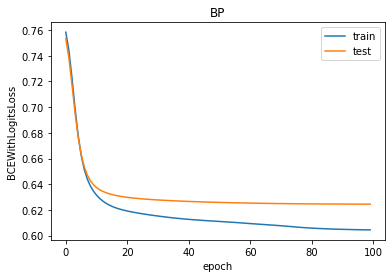

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_lost_profile, label = 'train')
plt.plot(test_lost_profile, label = 'test')
plt.title('BP')
plt.ylabel('BCEWithLogitsLoss')
plt.xlabel('epoch')
plt.legend()

# Validate our result

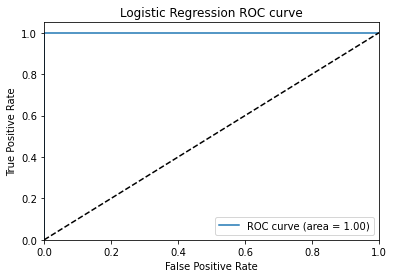

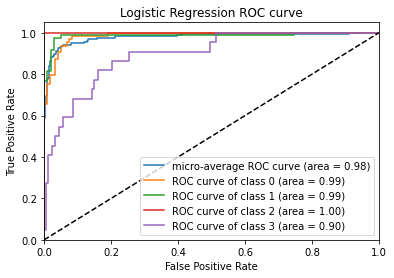

In [16]:
from ontoencoder.val import *

# detach torch.tensor and make into numpy
y_score = y_test_pred.detach().numpy()

multiple_class_roc(y_test, y_score) # it is a very easy task

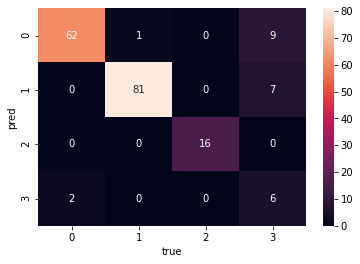

In [20]:
multiple_class_confusion_matrix(y_test, y_score)

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Interpret hidden variables

In [23]:
y_test_class = np.argmax(y_test, axis = 1)
y_pred_class = np.argmax(y_score, axis = 1)

In [24]:
from ontoencoder.interpret import *
df = hidden_to_pandas(model, y_pred_class, y_test_class)

In [25]:
df.head() # status of each system

,GO:0000301,GO:0000820,GO:0001519,GO:0001922,GO:0001973,GO:0001996,GO:0002337,GO:0002658,GO:0002940,GO:0002946,...,GO:1905838,GO:1990619,GO:1990785,GO:2001271,GO:0002465,GO:0070339,GO:0035483,GO:0008150,y_pred,y_true
0,0.325300,0.249201,0.124927,0.892415,-0.365677,-0.083914,-0.217074,0.369204,0.037368,0.503819,...,-0.041662,-0.256117,-0.156289,-0.064195,-0.359732,-0.206576,0.007513,0.0,1,1
1,0.088029,-0.012251,0.075242,0.182118,-0.152368,0.025774,-0.842045,0.353048,-0.538868,0.503819,...,0.258407,-0.537220,-0.156315,0.321138,-0.135571,-0.158298,0.007513,0.0,1,1
2,0.501569,0.377703,-0.716785,0.119822,-0.511383,-0.032455,-0.217074,0.353726,0.037368,-0.084217,...,0.275012,-0.523412,-0.156558,0.551756,-0.135341,-0.441433,0.007513,0.0,0,0
3,0.913127,0.363557,0.280863,-0.086594,0.608174,0.579193,-0.217074,0.347483,-0.973304,-0.280891,...,0.275012,-0.788610,-0.156558,0.760489,-0.137458,0.115256,0.007513,0.0,2,2
4,0.088029,0.339810,-0.093076,0.709022,-0.050181,0.364590,-0.277904,0.366493,-0.022087,0.503819,...,0.236805,-0.590782,-0.125063,0.762755,-0.131025,-0.114730,0.007513,0.0,1,1


In [28]:
stat_df = differential_hidden_state(df, cell_group = [0,1])
stat_df['reject'].sum()

47

In [29]:
stat_df.loc[stat_df['reject']].sort_values('t_abs', ascending = False)

,t,p-unadjusted,reject,name,t_abs
GO:0006540,42.029395,6.477870e-52,True,glutamate decarboxylation to succinate,42.029395
GO:0060173,-13.007426,4.779774e-26,True,limb development,13.007426
GO:0001519,-10.993347,3.291628e-21,True,peptide amidation,10.993347
GO:0006693,-9.846557,8.263106e-18,True,prostaglandin metabolic process,9.846557
GO:1905184,9.327379,9.591579e-15,True,positive regulation of protein serine/threonin...,9.327379
GO:0021570,-9.327379,9.591579e-15,True,rhombomere 4 development,9.327379
GO:0021568,9.327379,9.591579e-15,True,rhombomere 2 development,9.327379
GO:0097037,9.327379,9.591579e-15,True,heme export,9.327379
GO:0001973,-8.375814,3.013299e-14,True,adenosine receptor signaling pathway,8.375814
GO:0006525,-7.391824,4.025065e-11,True,arginine metabolic process,7.391824


In [30]:
stat_df.loc[~stat_df['reject']].sort_values('t_abs', ascending = False)

,t,p-unadjusted,reject,name,t_abs
GO:0035590,2.365489,0.019366,False,purinergic nucleotide receptor signaling pathway,2.365489
GO:0006541,-2.346716,0.020354,False,glutamine metabolic process,2.346716
GO:0021823,2.266852,0.024961,False,cerebral cortex tangential migration using cel...,2.266852
GO:0030320,2.229896,0.027402,False,cellular monovalent inorganic anion homeostasis,2.229896
GO:0019521,2.194356,0.030092,False,D-gluconate metabolic process,2.194356
...,...,...,...,...,...
GO:0036451,0.000000,1.000000,False,cap mRNA methylation,0.000000
GO:0030450,0.000000,1.000000,False,"regulation of complement activation, classical...",0.000000
GO:0060370,0.000000,1.000000,False,susceptibility to T cell mediated cytotoxicity,0.000000
GO:0042495,NaN,NaN,False,detection of triacyl bacterial lipopeptide,NaN


In [31]:
# anything we missed?
stat_df.loc[(~stat_df['reject']) &(stat_df['name'].str.contains('nerve'))]

,t,p-unadjusted,reject,name,t_abs
GO:0032902,-1.443156,0.15134,False,nerve growth factor production,1.443156


In [32]:
stat_df.loc[(~stat_df['reject']) &(stat_df['name'].str.contains('axon'))]

,t,p-unadjusted,reject,name,t_abs


In [33]:
stat_df.loc[(~stat_df['reject']) &(stat_df['name'].str.contains('synap'))]

,t,p-unadjusted,reject,name,t_abs
GO:0140245,1.018682,0.310007,False,regulation of translation at postsynapse,1.018682
